铁达尼号全部乘客的资料，包含乘客的id，姓名，年龄，票价等等，最后包含是否在灾难中生还的统计数据。虽然里面有部分数据缺失，但是整个数据可使用性非常好，非常时候做机器学习，而编写的难度也不高。

机器学习的一般流程包含如下几点
1、	数据清洗
2、	数据分析
3、	特征提取
4、	模型选择与训练
5、	预测与检验


In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [44]:
#查看获得的数据
titanic_train = pd.read_csv('../input/train.csv')
titanic_test = pd.read_csv('../input/test.csv')
titanic_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 数据结构
* csv上有12列，其中除去是否生还“Survived”将作为我们的预测列，数据展现一共有11个特征
* Pclass：票的类型有3种，需要深入查看三种类型的乘客数量分布
* 年龄和票价都是序列数值类型，要查看其中的最大最小值，简单的分布情况。

In [45]:
titanic_train.info()
print('_'*50)
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         41

训练集上年龄、船舱号码、登船港口都有缺失值

测试集上年龄、船舱号码、票价、登船港口都有缺失值

In [46]:
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [47]:
titanic_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,347082,C23 C25 C27,S
freq,1,577,7,4,644


* 从性别上看，男女分布比较均匀，65% 是男性
* 最多人在S号港口登船
* 票的号码发现很多重复

## 数据清洗

通过票的类型以及乘客性别，预估缺失的年龄

In [48]:
titanic_train.groupby(['Pclass', 'Sex']).mean()[['Age']]

Age
Pclass Sex              
1      female  34.611765
       male    41.281386
2      female  28.722973
       male    30.740707
3      female  21.750000
       male    26.507589

使用对应的平均值，把空的数据填入

In [49]:
titanic_train['Age'][titanic_train.Age.isnull()].head()

5    NaN
17   NaN
19   NaN
26   NaN
28   NaN
Name: Age, dtype: float64

训练集合上 5， 17 ，19， 26， 28行为NaN

In [50]:
titanic_train.loc[titanic_train.Age.isnull(), 'Age'] = titanic_train.groupby(['Pclass', 'Sex'])['Age'].transform('mean')
titanic_test.loc[titanic_test.Age.isnull(), 'Age'] = titanic_test.groupby(['Pclass', 'Sex'])['Age'].transform('mean')

In [51]:
titanic_train.iloc[[5, 17, 19, 26, 28]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,26.507589,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,30.740707,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,21.750000,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,26.507589,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,21.750000,0,0,330959,7.8792,NaN,Q


Embarked 登船港口只缺失了2个，我们用出现最多的“S”填充。

In [52]:
titanic_train['Embarked'].fillna("S", inplace=True)

In [53]:
titanic_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [54]:
titanic_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

现在训练集只剩下Cabin，但是由于Cabin的缺失太多了，没有特殊的办法处理，后面训练的时候只能去掉。把测试集合上缺失的票价补上。因为只有一个缺失值，直接使用中位数补全。

In [55]:
titanic_test['Fare'].fillna(titanic_test['Fare'].median(), inplace = True)

## 分析各项特征
我们大致猜测，铁达尼号乘客的生还的因素可能应该跟票的等级有关，还有票价。以及电影中我们看到沉船的时刻老人、小孩、妇女优先上救生艇，因此猜测还与年龄、性别有关系，逐一开始验证。


In [56]:
titanic_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


票等级高的人生存率明显比低级的高

In [57]:
titanic_train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


女性生还率更高

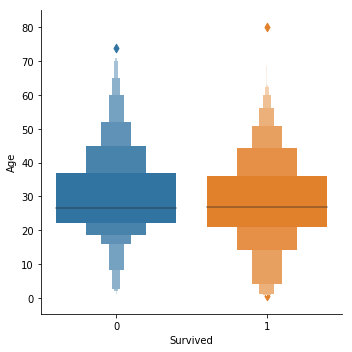

In [58]:
sns.factorplot(x="Survived", y = "Age",data=titanic_train, kind="boxen")

从年龄上看，基本差不多，年纪小的相对生还比较大

In [59]:
titanic_train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [60]:
titanic_train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [61]:
titanic_train["FamilySize"] = (titanic_train["SibSp"]+titanic_train["Parch"])
titanic_test["FamilySize"] = (titanic_test["SibSp"]+titanic_test["Parch"])
titanic_train[["FamilySize", "Survived"]].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,3,0.724138
2,2,0.578431
1,1,0.552795
6,6,0.333333
0,0,0.303538
4,4,0.200000
5,5,0.136364
7,7,0.000000
8,10,0.000000


家庭规模在2-4人的情况下，存活的概率比较大。这个涉及的因素有点多，一个家庭里面有男性、女性，成员年龄结构分布也比较大。大于5人的家庭，存活率很低，果然一家人最重要齐齐整整。

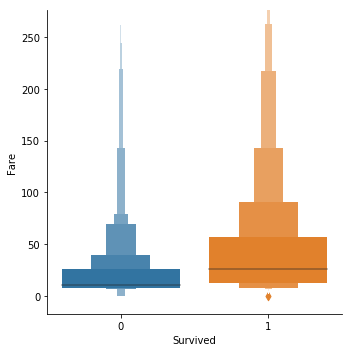

In [62]:
sns.factorplot(x="Survived", y = "Fare",data=titanic_train, kind="boxen")

票价高的明显存活率高于票价低

In [63]:
titanic_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


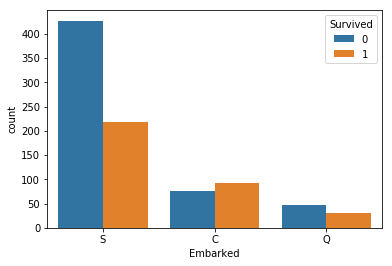

In [64]:
sns.countplot(x = 'Embarked', hue = 'Survived', data=titanic_train)

在C港口登船的客人生还更高一些

## 特征工程

In [65]:
dftrain = titanic_train.copy()
dftest = titanic_test.copy()

删除名字，票号以及舱位

In [66]:
for data in [dftrain, dftest]:
    data.drop(["Name", "Ticket", "Cabin"], axis=1, inplace=True)

In [67]:
data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
0,892,3,male,34.5,0,0,7.8292,Q,0
1,893,3,female,47.0,1,0,7.0000,S,1
2,894,2,male,62.0,0,0,9.6875,Q,0
3,895,3,male,27.0,0,0,8.6625,S,0
4,896,3,female,22.0,1,1,12.2875,S,2


对年龄Age进行切割编码

In [68]:
dftrain.describe()['Age']

count    891.000000
mean      29.318643
std       13.281103
min        0.420000
25%       21.750000
50%       26.507589
75%       36.000000
max       80.000000
Name: Age, dtype: float64

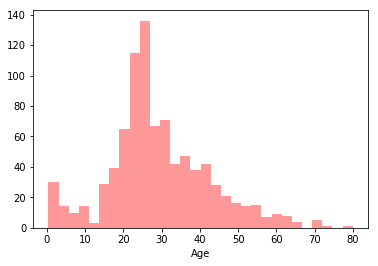

In [69]:
sns.distplot(dftrain['Age'], color='r', bins=30, kde=False)

年龄区间定在(0, 13, 21, 26, 36, 80)

In [70]:
for data in [dftrain, dftest]:
    interval = (0, 13, 21, 26, 36, 80)
    names = ["0-13","13-21","21-26","26-36","36-80"]
    data["Age"] = pd.cut(data.Age, interval, labels=names)

In [71]:
dftrain.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
0,1,0,3,male,21-26,1,0,7.2500,S,1
1,2,1,1,female,36-80,1,0,71.2833,C,1
2,3,1,3,female,21-26,0,0,7.9250,S,0
3,4,1,1,female,26-36,1,0,53.1000,S,1
4,5,0,3,male,26-36,0,0,8.0500,S,0


对Fare进行切割

In [72]:
dftrain.describe()['Fare']

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

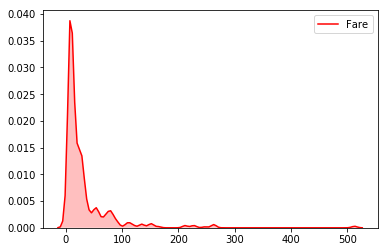

In [73]:
sns.kdeplot(dftrain["Fare"], color="Red", shade = True)

In [74]:
for data in [dftrain, dftest]:
    interval = (0, 8, 15, 31, 512)
    names = ["Price0-8","Price8-15","Price15-31","Price31-512"]
    data["Fare"] = pd.cut(data.Fare, interval, labels=names)

In [75]:
dftrain.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
0,1,0,3,male,21-26,1,0,Price0-8,S,1
1,2,1,1,female,36-80,1,0,Price31-512,C,1
2,3,1,3,female,21-26,0,0,Price0-8,S,0
3,4,1,1,female,26-36,1,0,Price31-512,S,1
4,5,0,3,male,26-36,0,0,Price8-15,S,0


FamilySize已经包含两者信息，去掉SibSp Parch

In [76]:
for data in [dftrain, dftest]:
    data.drop(["SibSp", "Parch"], axis=1, inplace=True)

In [77]:
dftrain.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
0,1,0,3,male,21-26,Price0-8,S,1
1,2,1,1,female,36-80,Price31-512,C,1
2,3,1,3,female,21-26,Price0-8,S,0
3,4,1,1,female,26-36,Price31-512,S,1
4,5,0,3,male,26-36,Price8-15,S,0


In [78]:
endftrain = pd.get_dummies(dftrain)
endftrain.head()

,PassengerId,Survived,Pclass,FamilySize,Sex_female,Sex_male,Age_0-13,Age_13-21,Age_21-26,Age_26-36,Age_36-80,Fare_Price0-8,Fare_Price8-15,Fare_Price15-31,Fare_Price31-512,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1
1,2,1,1,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0
2,3,1,3,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1
3,4,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1
4,5,0,3,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1


In [79]:
endftest = pd.get_dummies(dftest)
endftest.head()

,PassengerId,Pclass,FamilySize,Sex_female,Sex_male,Age_0-13,Age_13-21,Age_21-26,Age_26-36,Age_36-80,Fare_Price0-8,Fare_Price8-15,Fare_Price15-31,Fare_Price31-512,Embarked_C,Embarked_Q,Embarked_S
0,892,3,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0
1,893,3,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1
2,894,2,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0
3,895,3,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1
4,896,3,2,1,0,0,0,1,0,0,0,1,0,0,0,0,1


## 模型训练

In [117]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [81]:
endftrain.head()

,PassengerId,Survived,Pclass,FamilySize,Sex_female,Sex_male,Age_0-13,Age_13-21,Age_21-26,Age_26-36,Age_36-80,Fare_Price0-8,Fare_Price8-15,Fare_Price15-31,Fare_Price31-512,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1
1,2,1,1,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0
2,3,1,3,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1
3,4,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1
4,5,0,3,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1


把测试集分成train和test

In [82]:
X = endftrain.drop(columns=['PassengerId', 'Survived'], axis=1)
Y = endftrain['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.30,
                                                    random_state=123, 
                                                    stratify=Y)

先用随机森林测试

In [115]:
def randomforestregressor(X_train, X_test, y_train, y_test ):
    pipeline = make_pipeline(RandomForestClassifier(n_estimators=10))
    hyperparameters = { 'randomforestclassifier__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestclassifier__max_depth': [None, 5, 3, 1]}
    clf = GridSearchCV(pipeline, hyperparameters, cv=10)
    clf.fit(X_train, y_train)
    print(clf.best_params_)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [116]:
randomforestregressor(X_train, X_test, y_train, y_test)

{'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 'sqrt'}


0.8134328358208955

试一下SVC

In [113]:
def my_svc(X_train, X_test, y_train, y_test):
    svc = SVC()
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [114]:
my_svc(X_train, X_test, y_train, y_test)

0.8171641791044776

再试一下KNN

In [141]:
def knn(X_train, X_test, y_train, y_test):
    best = 0
    n = None
    for i in range(1, 15):
        knn = KNeighborsClassifier(n_neighbors = i)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        tmp_best = accuracy_score(y_test, y_pred)
        if best < tmp_best:
            best = tmp_best
            n = i
    print("Best n is:"+str(n))
    return best

In [142]:
knn(X_train, X_test, y_train, y_test)

Best n is:9


0.832089552238806

从上面3个模型，最高分的是KNN，当n为9时

把整个测试集合当输入训练，然后预测测试数据

In [143]:
endftest.head()

,PassengerId,Pclass,FamilySize,Sex_female,Sex_male,Age_0-13,Age_13-21,Age_21-26,Age_26-36,Age_36-80,Fare_Price0-8,Fare_Price8-15,Fare_Price15-31,Fare_Price31-512,Embarked_C,Embarked_Q,Embarked_S
0,892,3,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0
1,893,3,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1
2,894,2,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0
3,895,3,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1
4,896,3,2,1,0,0,0,1,0,0,0,1,0,0,0,0,1


In [145]:
knn_model = KNeighborsClassifier(n_neighbors = 9)
knn_model.fit(X, Y)
x_test = endftest.drop(columns=['PassengerId'], axis=1)
y_pred = knn_model.predict(x_test)

In [147]:
submission = pd.DataFrame({
        "PassengerId": endftest["PassengerId"],
        "Survived": y_pred
    })

In [149]:
submission.head(50)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [153]:
# submission.to_csv('titanic-predictions-submission.csv', index=False)